In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import seaborn as sns
from matplotlib import style
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from scipy.integrate import odeint
from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
import scipy
import warnings


from tqdm import tqdm 
from p_tqdm import p_map # For parallel processing and progress bar
import time
#import qmcpy as qp # For sampling using a variety of different methods much as Latin hypercube or sobo sequences
from scipy import signal # for smoothing
import os

from functools import partial

cwd = "Data/"

#THEANO_FLAGS = "optimizer=fast_compile"
print('Finished importing...')

Finished importing...


In [2]:
sim_counter = 0

def print_counter():
    global sim_counter 
    sim_counter += 1
    print('\r', sim_counter, sep='', end='', flush=True)
    return

In [3]:
medium_size = 22
large_size = 30

plt.style.use('dark_background')
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (9,4.5)

plt.rc('axes', labelsize=large_size)
plt.rc('axes', titlesize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.rc('legend', fontsize=medium_size)
plt.rcParams["figure.figsize"] = (16,9)
plt.rc('grid', linestyle=':', color='white', alpha=0.7, linewidth=2)

orange = (237/255, 125/255, 49/255, 1)
green = (0/255, 255/255, 0/255, 1)
red = (1, 0, 0, 1)

In [4]:
def derivatives(X, t, k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off):	
    # Model B.1c 
    CB       = X[0]
    S        = X[1]
    CBS      = X[2]
    C1       = X[3]
    CBC1     = X[4]
    CBC1S    = X[5]
    P2       = X[6]
    C1P2     = X[7]
    CBC1P2S  = X[8]
    CBC1P2   = X[9]
    C        = X[10]
    B        = X[11]
    BC1      = X[12]
    BC1P2    = X[13]

    return np.array([
        - d_on*CB*C1P2 + d_off*CBC1P2 - d_on*CB*C1 + d_off*CBC1 - k_on*CB*S + k_off_star*CBS + b_on*C*B - b_off*CB,
        - k_on*CB*S + k_off_star*CBS - R_on*CBC1P2*S + R_off*CBC1P2S - k_on*CBC1*S + k_off_star*CBC1S,
        k_on*CB*S - k_off_star*CBS - d_on*CBS*C1 + d_off*CBC1S - d_on*CBS*C1P2 + d_off*CBC1P2S,
        - d_on*CB*C1 + d_off*CBC1 - d_on*CBS*C1 + d_off*CBC1S - a_on*C1*P2 + a_off*C1P2 - d_on*B*C1 + d_off*BC1,
        - a_on*CBC1*P2 + a_off*CBC1P2 + d_on*CB*C1 - d_off*CBC1 - k_on*CBC1*S + k_off_star*CBC1S + b_on*C*BC1 - b_off*CBC1,
        d_on*CBS*C1 - d_off*CBC1S - a_on*CBC1S*P2 + a_off*CBC1P2S + k_on*CBC1*S - k_off_star*CBC1S,
        - a_on*CBC1*P2 + a_off*CBC1P2 - a_on*C1*P2 + a_off*C1P2 - a_on*CBC1S*P2 + a_off*CBC1P2S - a_on*BC1*P2 + a_off*BC1P2,
        - d_on*CB*C1P2 + d_off*CBC1P2 + a_on*C1*P2 - a_off*C1P2 - d_on*CBS*C1P2 + d_off*CBC1P2S - d_on*B*C1P2 + d_off*BC1P2,
        R_on*CBC1P2*S - R_off*CBC1P2S + a_on*CBC1S*P2 - a_off*CBC1P2S + d_on*CBS*C1P2 - d_off*CBC1P2S,
        a_on*CBC1*P2 - a_off*CBC1P2 + d_on*CB*C1P2 - d_off*CBC1P2 - R_on*CBC1P2*S + R_off*CBC1P2S + b_on*C*BC1P2 - b_off*CBC1P2,
        - b_on*C*B + b_off*CB - b_on*C*BC1 + b_off*CBC1 - b_on*C*BC1P2 + b_off*CBC1P2,
        - b_on*C*B + b_off*CB - d_on*B*C1 + d_off*BC1 - d_on*B*C1P2 + d_off*BC1P2,
        d_on*B*C1 - d_off*BC1 - b_on*C*BC1 + b_off*CBC1 - a_on*BC1*P2 + a_off*BC1P2,
        d_on*B*C1P2 - d_off*BC1P2 - b_on*C*BC1P2 + b_off*CBC1P2 + a_on*BC1*P2 - a_off*BC1P2])

In [5]:
def hetero_dimerisation_limit(kd, x_0, y_0):
    ''' Yeilds the concentration of the dimer in the limit as t goes to infinity '''
    return (x_0 + y_0 + kd - np.sqrt((x_0 + y_0 + kd)**2 - 4 * x_0 * y_0)) / 2

In [6]:
# Dictionary for quick lookup of index corresponding to variable name
var = {
    'CB':0,
    'S':1,
    'CBS':2,
    'C1':3,
    'CBC1':4,
    'CBC1S':5,
    'P2':6,
    'C1P2':7,
    'CBC1P2S':8,
    'CBC1P2':9,
    'C':10,
    'B':11,
    'BC1':12,
    'BC1P2':13
}

In [7]:
def ODE_limit(initial_concentrations, k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off):
    arr = []
    differences = []
    for i in tqdm(range(len(k_on))):
        Y = odeint(derivatives, initial_concentrations[i], t, args=(k_on[i], d_on[i], d_off[i], a_on[i], a_off[i], R_on[i], R_off[i], k_off_star[i], b_on[i], b_off[i],))
        arr.append(Y[-1, :])
        differences.append(np.max(Y[-1, :] - Y[-int(0.2*len(t)), :]))
        
    percentage_diff = np.max(100*np.array(differences).flatten())
    print("Max Percentage difference over the last 200 points = {:0.2f}".format(percentage_diff))
    return np.array(arr)

In [8]:
def single_component(t, k_OFF, A):
    return A * (1 - np.exp(-k_OFF * t))

def single_component_normalised(t, k_OFF):
    return 1 - np.exp(-k_OFF * t)

#def two_components(t, k_S, k_N, S, N):
def two_components(t, k_S, k_N):
    return S_ - S_ * np.exp(-k_S * t) + N_ - N_ * np.exp(-k_N * t)

def two_components_normalised(t, k_S, k_N, A):
    return A * np.exp(-k_S * t) + (1 - A) * np.exp(-k_N * t)

def two_components_full(t, k_S, k_N, S, N):
    return S - S * np.exp(-k_S * t) + N - N * np.exp(-k_N * t)

In [9]:
def generate_apparent_off_rates_full(k_on,  
                                     d_on, 
                                     #d_off, 
                                     a_on, 
                                     a_off, 
                                     R_on, 
                                     R_off, 
                                     k_off_star, 
                                     b_on, 
                                     b_off, 
                                     initial_concentrations,
                                     d_off,
                                     percentage_left=0, 
                                     measurement_time=20000, 
                                     measurement_steps=int(1E3)):
    '''
    Generates an in silico FRAP measurement that is fit using a 1 component reaction limited model (DNA binding model) by removing all bound species and then observing their recoveries
    '''
    #print_counter()
    #print('d_off = {:0.2e}'.format(d_off))
    times = np.linspace(0, measurement_time, num=measurement_steps)
    # Allow system to go to equilibrium before bleaching
    Y = odeint(derivatives, initial_concentrations, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    bleached_concs = Y[-1, :]
    # Reset the concentrations according to what percentage of the bound molecules is bleached
    bleached_concs[var['S']] = Y[0, var['S']] 
    bleached_concs[var['CBS']] = percentage_left * bleached_concs[var['CBS']] 
    bleached_concs[var['CBC1S']] = percentage_left * bleached_concs[var['CBC1S']] 
    bleached_concs[var['CBC1P2S']] = percentage_left * bleached_concs[var['CBC1P2S']]
    
    # Simulate system after bleaching
    Y2 = odeint(derivatives, bleached_concs, times, args=(k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off))
    Y_copy = Y2.copy()
    t_end = int(0.8*measurement_steps)
    t_ = times[:-t_end]
    try:
        all_unbound = Y_copy[-1, var['CB']] + Y_copy[-1, var['CBC1']] + Y_copy[-1, var['CBC1P2']]
        all_bound = Y_copy[-1, var['CBS']] + Y_copy[-1, var['CBC1S']] + Y_copy[-1, var['CBC1P2S']]
        k_off_pred = k_on * Y_copy[-1, var['S']] * (all_unbound / all_bound)
        
        result = np.zeros(15)
        result[0] = k_off_pred
        result[1:] = Y[-2, :]
        return result

    except Exception as e:
        params = [k_on, d_on, d_off, a_on, a_off, R_on, R_off, k_off_star, b_on, b_off]
        print('ERROR: {:} with values: \n Y_bleached_p={:}  \n Y_bleached_p_min={:} \n params = {:} \n Y_bleached_p_2 = {:} \n Y_bleached_p_max = {:} \n Y_bleached_p_3 = {:} \n Returning zero'.format(e, Y_bleached_p, np.min(Y_bleached_p), params, Y_bleached_p_2, Y_bleached_p_max, Y_bleached_p_3))
        print('ERROR: {:} \n Returning None'.format(e))
        #raise('MEH')
        result = np.zeros(15)
        result[0] = 0#fit_params[0]
        result[1:] = Y2[-1, :]
        return result
    

In [14]:
measured_param_dists = pd.read_excel(os.path.join(cwd, 'allValuesReferenceTable.xlsx'), sheet_name='MeasuredParamtersDistributions', header=[1, 2, 3])
measured_param_dists

Unnamed: 0_level_0    TG-BMAL1                            TG-BMAL1xCRY1  \
     Unnamed: 0_level_1        kOFF                                     kOFF   
     Unnamed: 0_level_2 Fibroblasts Aveolar Mθ    PECS    BMDM        Pooled   
0                   NaN      0.2752     0.4164  0.1636     NaN        0.5734   
1                   NaN      0.4403     0.7832  0.2445  0.2555        0.4684   
2                   NaN      0.3790     0.3345  0.2541  0.6274        0.4566   
3                   NaN      0.4001     0.2721  0.2984  0.4654        0.5041   
4                   NaN      0.3398     0.3428  1.2756  0.6341        0.2638   
...                 ...         ...        ...     ...     ...           ...   
1682                NaN         NaN        NaN     NaN     NaN           NaN   
1683                NaN         NaN        NaN     NaN     NaN           NaN   
1684                NaN         NaN        NaN     NaN     NaN           NaN   
1685                NaN         NaN        NaN     NaN     NaN           NaN   
1686                NaN         NaN        NaN     NaN     NaN           NaN   

     LV-BMAL1:CLOCK       BMAL1                       ...   BMAL1xCRY1  \
               kOFF   Conc (nM)                       ...    Diffusion   
       LV2-WT-Bmal1 Fibroblasts Aveolar Mθ      PECS  ... BMAL1_Pooled   
0            0.5037    7.179150   8.882740  3.347469  ...     0.476208   
1            0.2629   11.373760  10.881390  8.641375  ...     0.294933   
2            0.2817    8.214091  10.970670  6.228474  ...     0.662486   
3            1.1838    7.952958  16.237790  3.597363  ...     0.489105   
4            0.1367    7.136958   6.076025  5.532853  ...     0.642596   
...             ...         ...        ...       ...  ...          ...   
1682            NaN   11.801990        NaN       NaN  ...          NaN   
1683            NaN    8.850902        NaN       NaN  ...          NaN   
1684            NaN   12.756440        NaN       NaN  ...          NaN   
1685            NaN    7.502801        NaN       NaN  ...          NaN   
1686            NaN    7.917856        NaN       NaN  ...          NaN   

                            LV1-CRY1            LV1-PER2                      \
                           Diffusion           Diffusion                       
     CRY1_Pooled Unnamed: 23_level_2 Unnamed: 24_level_2 Unnamed: 25_level_2   
0       1.164704            1.356272            0.108505                 NaN   
1       0.728200            1.661385            0.187150                 NaN   
2       0.663132            1.181511            0.596182                 NaN   
3       0.786792            0.989835            0.149888                 NaN   
4       0.592117            0.922632            0.178628                 NaN   
...          ...                 ...                 ...                 ...   
1682         NaN                 NaN                 NaN                 NaN   
1683         NaN                 NaN                 NaN                 NaN   
1684         NaN                 NaN                 NaN                 NaN   
1685         NaN                 NaN                 NaN                 NaN   
1686         NaN                 NaN                 NaN                 NaN   

                                                                  \
                                                                   
     Unnamed: 26_level_2 Unnamed: 27_level_2 Unnamed: 28_level_2   
0                    NaN                 NaN                 NaN   
1                    NaN                 NaN                 NaN   
2                    NaN                 NaN                 NaN   
3                    NaN                 NaN                 NaN   
4                    NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
1682                 NaN                 NaN                 NaN   
1683                 NaN                 NaN  

In [15]:
measured_param_single_values = pd.read_excel(os.path.join(cwd, 'allValuesReferenceTable.xlsx'), sheet_name='MesuredParametersSingleValues', header=[1, 2, 3], index_col=0)
measured_param_single_values

BMAL1:CLOCK                         BMAL1:CRY1 NLSEGFP:CLOCK  \
          kd (nM)                            kd (nM)       kd (nM)   
           LV2-WT    LV2-L95E LV2-V435R       Pooled           LV2   
Mean   147.644673  147.710634       NaN    50.332424           NaN   
StDev    9.837618    7.485626       NaN     1.078076           NaN   
N      136.000000  274.000000       NaN  1039.000000           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   
NaN           NaN         NaN       NaN          NaN           NaN   

        PER1:CRY1   PER1:CRY2                                                  \
          kd (nM)     kd (nM)                                                   
              LV2         LV2 LV2.1 LV2.2 LV2.3 LV2.4 LV2.5 LV2.6 LV2.7 LV2.8   
Mean   150.916802  202.474737   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
StDev   12.527938   26.621013   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
N      120.000000   93.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN           NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                    
                    
      LV2.9 LV2.10  
Mean    NaN    NaN  
StDev   NaN    NaN  
N       NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN  
NaN     NaN    NaN

In [16]:
pooled_data = pd.read_excel(os.path.join(cwd, 'allValuesForHistogram.xlsx'), sheet_name='Variables')
pooled_data

,[Per2],[Bmal1],[Cry1]
0,Taken from Per2::Venus lung fibroblasts at bas...,Taken from Venus::Bmal1 all cells at basal con...,NaN
1,NaN,18.8704,2.981959
2,NaN,34.1538,4.179593
3,NaN,13.2102,3.011334
4,NaN,10.1185,4.771489
...,...,...,...
2107,NaN,1.60623,NaN
2108,NaN,4.22581,NaN
2109,NaN,2.52152,NaN
2110,NaN,1.69514,NaN


In [17]:
timelapse_data = pd.read_csv(os.path.join(cwd, 'Bmal1xCry1 3-3-21 XY Mean and Error.csv'))
timelapse_data

,Unnamed: 0,Interaction,Interaction.1,Interaction.2,Bmal1 Concentration,Bmal1 Concentration.1,Bmal1 Concentration.2,Bmal1 Diffusion,Bmal1 Diffusion.1,Bmal1 Diffusion.2,...,Bmal1 Alpha.2,Cry1 Concentration,Cry1 Concentration.1,Cry1 Concentration.2,Cry1 Diffusion,Cry1 Diffusion.1,Cry1 Diffusion.2,Cry1 Alpha,Cry1 Alpha.1,Cry1 Alpha.2
0,24,46.80251,2.227670,136,22.56,7.084,136,0.5879,0.2577,136,...,136,5.877,3.052,136,0.6706,0.3646,136,0.4137,0.10070,136
1,28,38.81192,2.088515,143,20.14,6.089,143,0.5777,0.2584,143,...,143,5.718,2.714,143,0.5612,0.3153,143,0.3913,0.09902,143
2,32,52.42218,3.421946,173,21.45,6.764,173,0.5416,0.2493,173,...,173,7.283,6.716,173,0.5655,0.3184,173,0.4010,0.10430,173
3,36,51.65048,2.351429,131,26.93,8.930,131,0.6042,0.2705,131,...,131,6.256,4.162,131,0.7180,0.3308,131,0.4203,0.09287,131
4,40,65.11347,3.358420,158,33.32,13.610,158,0.5363,0.2682,158,...,158,6.686,3.958,158,0.6882,0.3970,158,0.4043,0.10860,158
5,44,54.17862,2.832088,121,27.70,8.804,121,0.6037,0.2397,121,...,121,6.099,3.137,121,0.7552,0.3677,121,0.4097,0.08304,121
6,48,41.71945,2.266186,132,23.53,8.496,132,0.5974,0.2393,132,...,132,5.959,2.458,132,0.6258,0.3123,132,0.4123,0.09710,132


In [18]:
kOFF_timelapse_data = pd.read_csv(os.path.join(cwd, 'kOFF error allReps.csv'))
kOFF_timelapse_data

,Time (hours after dexamethasone),Mean,SD,N
0,24,2.732,1.082,48
1,28,2.399,1.215,70
2,32,2.359,1.251,82
3,36,2.594,1.079,63
4,40,3.038,1.499,82
5,44,2.733,1.279,64
6,48,2.513,1.168,65


In [20]:
per_data = pd.read_csv(os.path.join(cwd, 'Smyllie-PER2-Protein trace.csv'))
per_data

,X,LOWESS of Per2 Protein,LOWESS of Per2 Protein.1,LOWESS of Per2 Protein.2
0,0.000000,1.507303,0.642413,8
1,0.277213,1.800158,0.601391,8
2,0.554425,2.093012,0.582516,8
3,0.831638,2.385867,0.587924,8
4,1.108850,2.678722,0.616978,8
...,...,...,...,...
283,78.451150,7.981321,2.194489,8
284,78.728362,7.965996,2.336698,8
285,79.005575,7.950672,2.492308,8
286,79.282787,7.935347,2.658968,8


In [22]:
t = per_data['X']

p2_data = per_data['LOWESS of Per2 Protein'].to_numpy()

(24.0, 48.0)

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


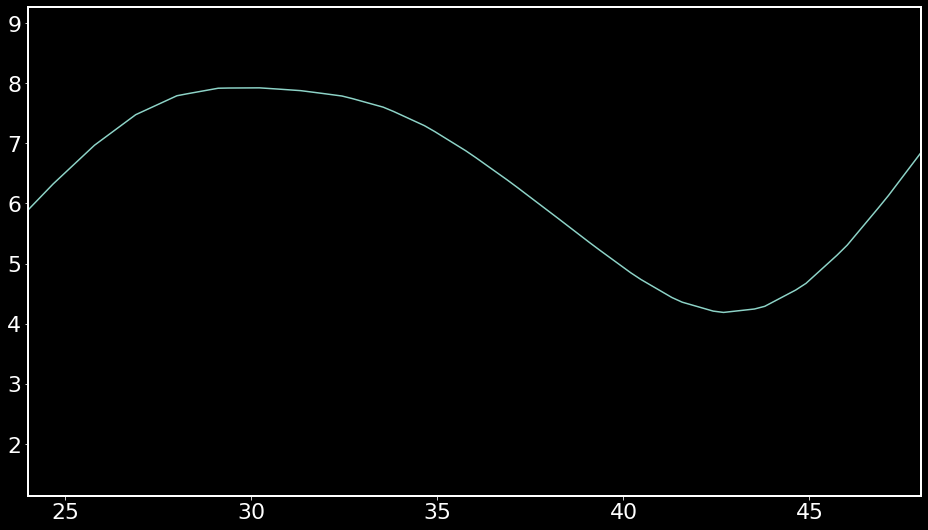

In [23]:
plt.plot(t, p2_data)
plt.xlim([24, 48])

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


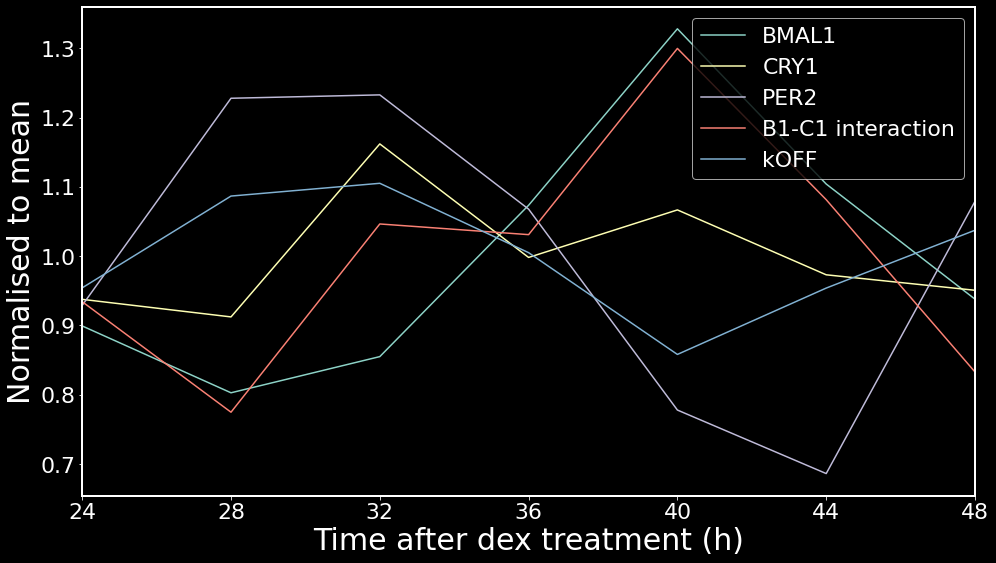

In [24]:
samples = 7

tps = np.linspace(24, 48, num=samples) # Timepoints where to evaluate the interpolation
#t_truncated_shifted = t_truncated + 4
exp_t = timelapse_data['Unnamed: 0']

Bmal1 = np.interp(tps, exp_t, timelapse_data['Bmal1 Concentration'])
bmal1_to_clock_ratio = 1.903 # bmal1 for every clock
Clock = np.interp(tps, exp_t, timelapse_data['Bmal1 Concentration']) / bmal1_to_clock_ratio
Cry1 = 2.083 * np.interp(tps, exp_t, timelapse_data['Cry1 Concentration'])
Per2 = np.interp(tps, t, p2_data)

kd_CB_C1s = np.interp(tps, exp_t, timelapse_data['Interaction'])
kd_CB_C1s_std = np.interp(tps, exp_t, timelapse_data['Interaction.1'])
kd_CB_C1s_N = np.interp(tps, exp_t, timelapse_data['Interaction.2'])
kd_SEM = np.power(1*(kd_CB_C1s_std/kd_CB_C1s_N), 2)

kOFF = np.interp(tps, kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['Mean'])
kOFF_std = np.interp(tps, kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['SD'])
kOFF_N = np.interp(tps, kOFF_timelapse_data['Time (hours after dexamethasone)'], kOFF_timelapse_data['N'])
kOFF = 1/kOFF # convert into off rate. Currently it is in residence time
kOFF_std = 1/kOFF_std 
kOFF_95_CI_on_mean = 1.96*(kOFF_std/kOFF_N)
kOFF_SEM = 1*(kOFF_std/kOFF_N)


plt.plot(tps, Bmal1/np.mean(Bmal1), label='BMAL1')
plt.plot(tps, Cry1/np.mean(Cry1), label='CRY1')
plt.plot(tps, Per2/np.mean(Per2), label='PER2')
plt.plot(tps, kd_CB_C1s/np.mean(kd_CB_C1s), label='B1-C1 interaction')
plt.plot(tps, kOFF/np.mean(kOFF), label='kOFF')
#plt.plot(tps, Clock/np.mean(Clock), label='Clock')

plt.xlim([24, 48])
plt.xlabel('Time after dex treatment (h)')
plt.ylabel('Normalised to mean')
plt.xticks([24, 28, 32, 36, 40, 44, 48])
plt.legend()

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


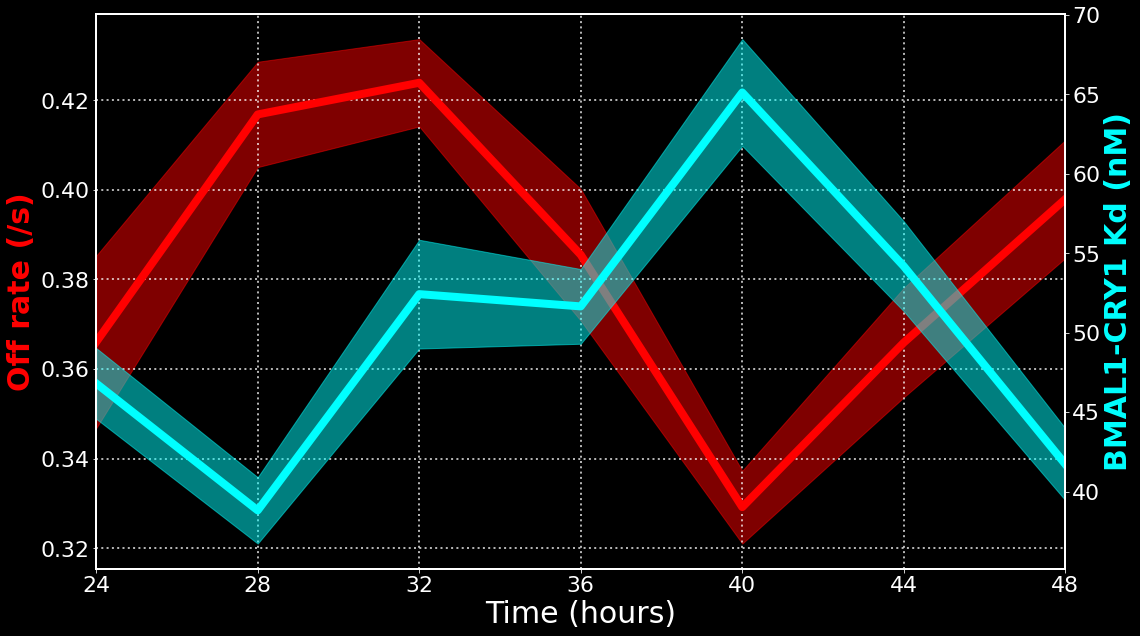

In [25]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Off rate (/s)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
ax1.plot(tps, kOFF, color=red, linewidth=8)
#ax1.fill_between(tps, kOFF - kOFF_std/kOFF_N, kOFF + kOFF_std/kOFF_N, color=red, alpha=0.5)
ax1.fill_between(tps, kOFF - kOFF_SEM, kOFF + kOFF_SEM, color=red, alpha=0.5)

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('BMAL1-CRY1 Kd (nM)', weight='bold', color='cyan')
ax2.plot(tps, kd_CB_C1s, color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
ax2.fill_between(tps, kd_CB_C1s - kd_CB_C1s_std, kd_CB_C1s + kd_CB_C1s_std, color='cyan', alpha=0.5)
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


In [26]:
class DNA_binding_model_B1:
    def __init__(self, samples, y0s, measurement_time, measurement_steps, C1_P2_Kd, CB_EBOX_Kd, CLK_B1_Kd, B1_C1_Kds, cores=4):
        self._y0s = y0s
        self._samples = int(samples)
        self._measurement_time = measurement_time
        self._measurement_steps = measurement_steps
        self._cores = cores
        self._C1_P2_Kd = C1_P2_Kd
        self._CB_EBOX_Kd = CB_EBOX_Kd
        self._CLK_B1_Kd = CLK_B1_Kd
        self._B1_C1_Kds = B1_C1_Kds

    def full_simulate(self, parameters):
        k_on, d_on, a_on, R_on, R_off, b_on = [float(x) for x in parameters]
        k_off_star = self._CB_EBOX_Kd * k_on
        a_off = self._C1_P2_Kd * a_on
        b_off = self._CLK_B1_Kd * b_on
        
        d_offs = self._B1_C1_Kds * d_on
        
        print_counter()
        result = np.zeros([self._samples, 15])
        result = p_map(partial(generate_apparent_off_rates_full,
                                        k_on, 
                                        d_on, 
                                        #d_off, 
                                        a_on, 
                                        a_off, 
                                        R_on, 
                                        R_off, 
                                        k_off_star, 
                                        b_on, 
                                        b_off, 
                                        measurement_time=self._measurement_time, 
                                        measurement_steps=self._measurement_steps), 
                                np.array(self._y0s), np.array(d_offs), num_cpus=self._cores, leave=False, disable=True)

        return np.array(result)
    
    def fit(self, param_bounds, data_means, data_variances, maxiter=1, polish=True):
        #data = np.array(data_means, data_variances)
        def sum_of_squared_errors(params):
            val = self.full_simulate(params)[:, 0]
            '''print('here')
            print(val)
            print(data_means)'''
            SSE = 0
            chi_squared = np.power((data_means - val), 2)/data_variances  #np.power((data_means - val), 2)/data_variances  
            SSE = np.sum(chi_squared)
            '''print('SSE')
            print(SSE)'''
            return SSE
        
        def generate_Initial_Parameters(bounds):
            boundsReshape = tuple(zip(*bounds))
            parameterBounds = []
            for i in range(len(boundsReshape)):
                parameterBounds.append(boundsReshape[i])
            print(np.array(parameterBounds).shape)
            print(parameterBounds)
            diff_evolution = scipy.optimize.differential_evolution(sum_of_squared_errors, parameterBounds, disp=True, maxiter=maxiter, polish=True)
            minimised = scipy.optimize.minimize(sum_of_squared_errors, diff_evolution.x, bounds=parameterBounds)
            print(minimised)
            return diff_evolution, minimised, diff_evolution.x, diff_evolution.fun
        
        diff_evolution, minimised, fitted_params, fitness = generate_Initial_Parameters(param_bounds)
        print('Fitted params: ')
        print(fitted_params)
        fitted_solution = self.full_simulate(fitted_params)
        
        return diff_evolution, minimised, fitted_params, fitted_solution, fitness

In [22]:
measured_param_single_values['BMAL1:CLOCK']['kd (nM)']['LV2-WT']['Mean'] # nM Disassociation constant between Clock and Bmal1

147.6446725113458

In [23]:
'''
    CB       = X[0]
    S        = X[1]
    CBS      = X[2]
    C1       = X[3]
    CBC1     = X[4]
    CBC1S    = X[5]
    P2       = X[6]
    C1P2     = X[7]
    CBC1P2S  = X[8]
    CBC1P2   = X[9]
    C        = X[10]
    B        = X[11]
    BC1      = X[12]
    BC1P2    = X[13]
'''

N_A = 6.022E23
kd_CB = measured_param_single_values['BMAL1:CLOCK']['kd (nM)']['LV2-WT']['Mean'] # nM Disassociation constant between Clock and Bmal1
kd_CB_C1 = measured_param_single_values['BMAL1:CRY1']['kd (nM)']['Pooled']['Mean']  # nM Disassociation constant between Bmal1 and Cry1
kd_C1_P2 = 82 # measured_param_single_values['PER1:CRY1']['kd (nM)']['LV2']['Mean'] # nM Disassociation constant between Per2 and Cry1
CB_EBOX_Kd = 10 # nM as measured by Partch lab
print(kd_CB)

D = np.mean(measured_param_dists['BMAL1xCRY1']['Diffusion']['BMAL1_Pooled'])     
a = 2.04E-3  # Size of promoter / searchable target in um, 6 * 0.34 length of a base pair)
V = 926.1E-15 # ±437.9 µm3 (n=116) Volume in fL as measured using Hoeschst staining of ALF cells

S = 3436 # Specific Binding sites
S = S * 1E9 / (N_A * V)
N = 200000 # Non-specific sites 
N = N * 1E9 / (N_A * V)
print('S = {:} nM, N = {:} nM'.format(S, N))


k_on = 4 * np.pi * D * a / (V * 1E15)
k_on /= 1/ (N_A * V)
print(k_on)
k_on /= 1E9
#k_on = 8E-5
print(k_on)

d_on = 4.73E4 # M^-1 s^-1 as measured by Carrie Partch
print(d_on)
d_on /= 1E9 # Convert to nM^-1 s^-1 
print(d_on)

a_on = 5E4 # M^-1 s^-1 Guess
print(a_on)
a_on /= 1E9
print(a_on)

d_off = kd_CB_C1 * d_on 
print('d_off = {:0.2e} s^-1'.format(d_off))

a_off = kd_C1_P2 * a_on 
print('a_off = {:0.2e} s^-1'.format(a_off))

#CB = hetero_dimerisation_limit(kd_CB, Bmal1, Bmal1/bmal1_to_clock_ratio)
#print('CB =')
#print(CB)

initial_concentrations = np.array([np.array([0.0]*14)]*samples)

initial_concentrations[:, var['S']] = S
#initial_concentrations[:, var['CB']] = CB
initial_concentrations[:, var['B']] = Bmal1
initial_concentrations[:, var['C']] = Clock
initial_concentrations[:, var['C1']] = Cry1
initial_concentrations[:, var['P2']] = Per2
initial_concentrations = initial_concentrations.astype('float64')
#print(initial_concentrations)

#print(k_on)
#print(a_on)
#print(a_off)


f_k_on = k_on
f_k_off = 0.3
f_k_off_star = 0.03
f_R_on = f_k_on # R_on
f_R_off = 0.3
f_a_on = a_on
f_a_off = a_off

a_off = 0.00030000000000000003

n_states = 1
n_times = samples

true_params = [9.83906286e-03,   # k_on
               3.63302761e-02,   # d_on
               1.79972287e-02,   # a_on
               1.36750328e-02,   # R_on
               6.12090423e+00,   # R_off
               1E-2]   # b_on 

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
#print('True params:')
#print(true_params)
ode_model = DNA_binding_model_B1(samples, initial_concentrations, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s, cores=20)

t0 = time.time()
result = ode_model.full_simulate(fitted_params)
#print(result.shape)
#print(result)
kOFF_sim = result[:, 0]
equilibrium_conc_sim = np.array([el[1:] for el in result])
#print(kOFF_sim)
#print(equilibrium_conc_sim)
t_end = time.time()
print('Time taken = {:0.2f}'.format(t_end-t0))

147.6446725113458
S = 6.161046970595631 nM, N = 358.6174022465443 nM
9234788.783008236
0.009234788783008237
47300.0
4.73e-05
50000.0
5e-05
d_off = 2.38e-03 s^-1
a_off = 4.10e-03 s^-1
1Time taken = 0.28


cheese


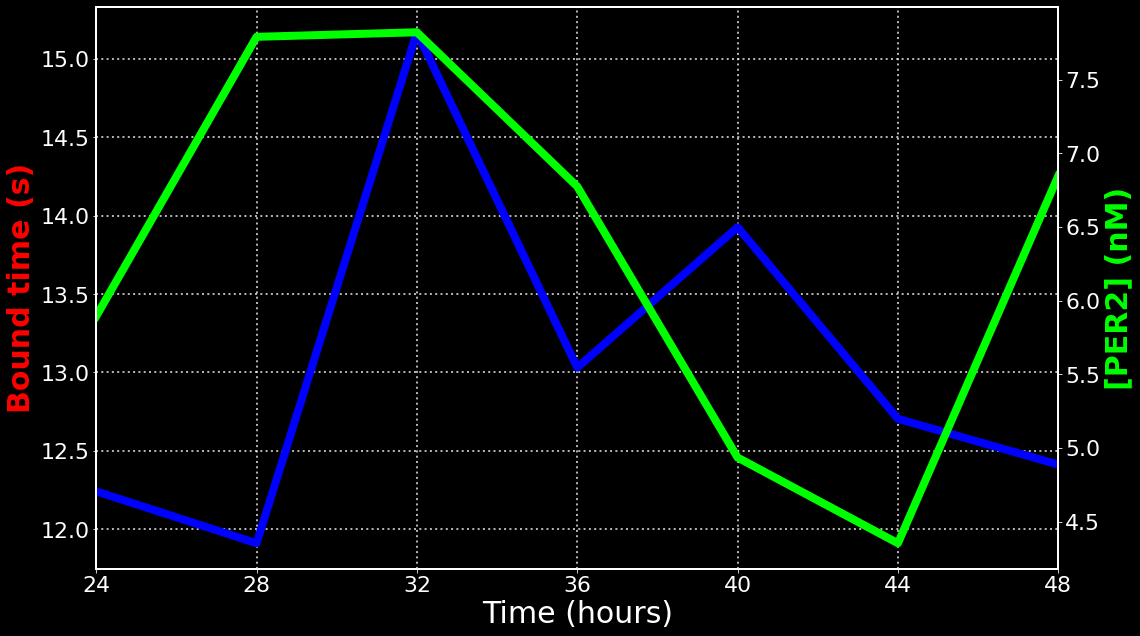

In [24]:
print('cheese')

np.random.seed(42)
noise_sigma = 0#0.001
#Y_sim = sim_data + np.random.randn(n_times, n_states) * noise_sigma
Y_sim = kOFF_sim + np.random.randn(n_times) * noise_sigma

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Bound time (s)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, 1/kOFF, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, 1/kOFF_sim, color='blue', linewidth=8, label='Residence time')
#ax1.plot(tps, 1/Y_sim, 'o', color='darkblue', label='Noisy data')
ax1.plot(tps, Cry1, color='blue', linewidth=8, label='Residence time')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[PER2] (nM)', weight='bold', color=green)
ax2.plot(tps, Per2, color=green, linewidth=8, label='Per2')
#ax2.plot(tps, kd_CB_C1s, color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax2.fill_between(tps, kd_CB_C1s - kd_CB_C1s_std/kd_CB_C1s_N, kd_CB_C1s + kd_CB_C1s_std/kd_CB_C1s_N, color='cyan', alpha=0.5)
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


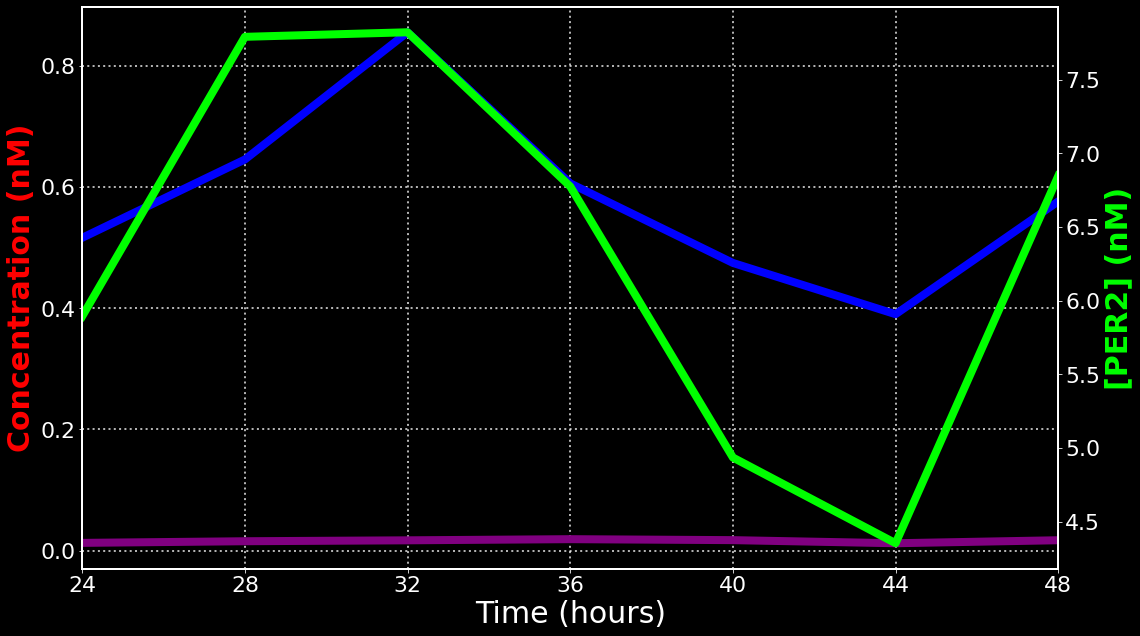

In [25]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Concentration (nM)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, signal.savgol_filter(equilibrium_conc_sim[:, var['BC1']], 11, 3), color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, equilibrium_conc_sim[:, var['BC1']], color='blue', linewidth=8, label='Residence time')

#ax1.plot(tps, 100*equilibrium_conc_sim[:, var['CBS']]/S, color='blue', linewidth=8, label='Residence time')
#ax1.plot(tps, 100*equilibrium_conc_sim[:, var['CBC1S']]/S, color='purple', linewidth=8, label='Residence time')
ax1.plot(tps, equilibrium_conc_sim[:, var['CBC1P2']], color='purple', linewidth=8, label='Residence time')
ax1.plot(tps, equilibrium_conc_sim[:, var['C1P2']], color='blue', linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim, 'o', color='darkred', label='Noisy data')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[PER2] (nM)', weight='bold', color=green)
ax2.plot(tps, Per2, color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

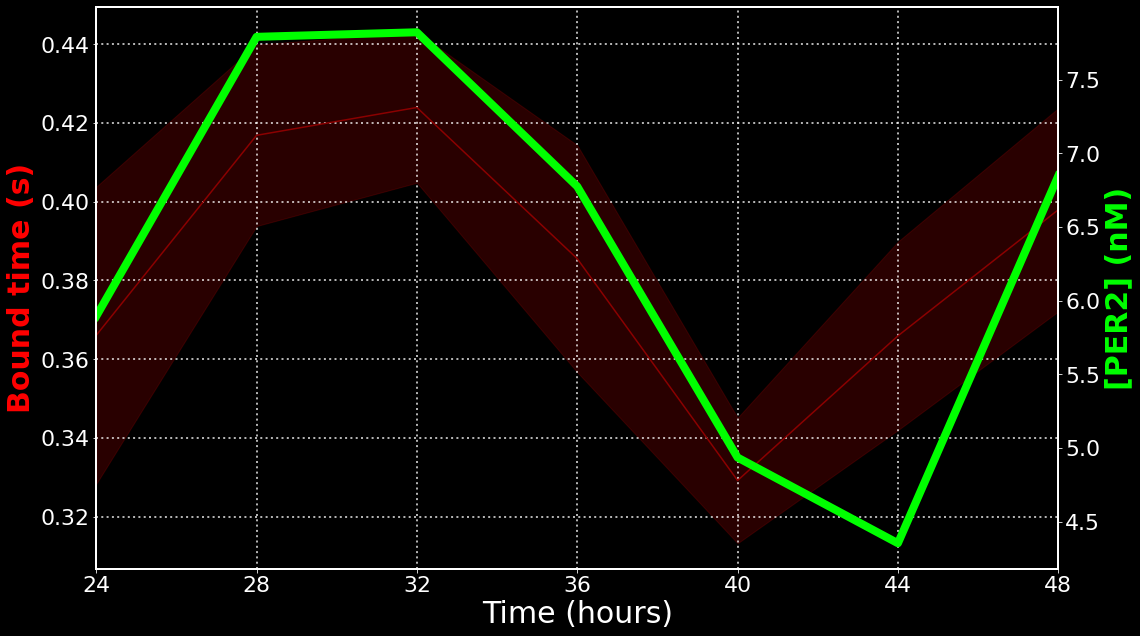

In [26]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Bound time (s)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, sim_data[:, 0], color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim[:, 0], 'o', color='darkred', label='Noisy data')
ax1.plot(tps, kOFF, '-', color='darkred', label='Noisy data')
ax1.fill_between(tps, (kOFF)-1.96*(kOFF_std/kOFF_N), (kOFF)+1.96*(kOFF_std/kOFF_N), color='darkred', alpha=0.3)
#ax1.fill_between(tps, (kOFF)-(kOFF_std), (kOFF)+(kOFF_std), color='darkred', alpha=0.3)
#ax1.plot(tps, 1/fitted_Y, 'o', color='blue', label='Fit')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[PER2] (nM)', weight='bold', color=green)
ax2.plot(tps, Per2, color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

In [26]:
bounds = [[1E-4, 1E-4, 1E-4, 1E-4, 1E-2, 1E-4], 
          [1E1, 1E1, 1E1, 1E1, 100, 1E1]]

'''true_params = [9.83906286e-03,   # k_on
               3.63302761e-02,   # d_on
               1.79972287e-02,   # a_on
               1.36750328e-02, # R_on
               6.12090423e+00,   # R_off
               1E-2]   # b_on'''

warnings.filterwarnings("ignore")
sim_counter = 0
#with np.errstate(over='ignore'): # ignore overflow warnings in exponential function

fitting_data = kOFF #np.array([kOFF, kd_CB_C1s]).transpose()
fitting_data_variances = np.power(kOFF_SEM, 2) #np.array([np.power(kOFF_SEM, 2), np.power(kd_CB_C1s_std, 2)]).transpose()
print(fitting_data.shape)
t0 = time.time()
diff_evolution, minimised, data_fitted_params, data_fitted_solution, data_fitness = ode_model.fit(bounds, fitting_data, fitting_data_variances, maxiter=200, polish=True)
t_end = time.time()
print('Time taken = {:0.2f}'.format(t_end-t0))
data_fitted_params

(7,)
(6, 2)
[(0.0001, 10.0), (0.0001, 10.0), (0.0001, 10.0), (0.0001, 10.0), (0.01, 100), (0.0001, 10.0)]
180differential_evolution step 1: f(x)= 7363.99
270differential_evolution step 2: f(x)= 970.133
360differential_evolution step 3: f(x)= 970.133
450differential_evolution step 4: f(x)= 355.806
540differential_evolution step 5: f(x)= 138.135
630differential_evolution step 6: f(x)= 122.948
720differential_evolution step 7: f(x)= 20.0167
810differential_evolution step 8: f(x)= 20.0167
900differential_evolution step 9: f(x)= 20.0167
990differential_evolution step 10: f(x)= 8.563
1080differential_evolution step 11: f(x)= 8.563
1170differential_evolution step 12: f(x)= 8.563
1260differential_evolution step 13: f(x)= 8.563
1350differential_evolution step 14: f(x)= 8.563
1440differential_evolution step 15: f(x)= 8.563
1530differential_evolution step 16: f(x)= 8.563
1620differential_evolution step 17: f(x)= 8.45227
1710differential_evolution step 18: f(x)= 8.45227
1800differential_evolution 

array([ 0.02684055,  1.15950831,  7.79829358,  0.07119678, 12.53193884,
        0.73620371])

In [27]:
data_fitted_params

array([ 0.02684055,  1.15950831,  7.79829358,  0.07119678, 12.53193884,
        0.73620371])

In [28]:
data_fitness

7.527315667257509

In [28]:
diff_evolution

     fun: 7.5359733929624495
     jac: array([-18.17756088,   1.16807604,   0.49221374,   1.0015305 ,
         0.16802789,   0.74773227])
 message: 'Optimization terminated successfully.'
    nfev: 6960
     nit: 74
 success: True
       x: array([ 0.02684055,  1.15950831,  7.79829358,  0.07119678, 12.53193884,
        0.73620371])

In [29]:
minimised.jac

array([ 1.132205  ,  0.08180514,  0.13539143,  0.15417632, -0.0286227 ,
       -0.37431462])

In [33]:
minimised

      fun: 7.53595708080248
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.132205  ,  0.08180514,  0.13539143,  0.15417632, -0.0286227 ,
       -0.37431462])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 77
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([ 0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821,
        0.7362028 ])

In [31]:
J = minimised.jac #diff_evolution.jac
print(J.shape)
print(minimised.x.shape)
I = np.zeros([6, 6])
J_mat = I
for i in range(6):     
    J_mat[i, i] = J[i]
    
cov = np.linalg.inv(J_mat.T.dot(J_mat))
var = np.sqrt(np.diagonal(cov))
std = np.sqrt(var)
std

(6,)
(6,)


array([0.93980438, 3.49630814, 2.71771811, 2.54677846, 5.91077852,
       1.6344875 ])

In [32]:
names = ['k_on', 'd_on', 'a_on', 'R_on', 'R_off', 'b_on']

for i in range(6):
    print('{:} = {:0.5e} +/- {:0.5e} ({:0.1f} %)'.format(names[i], minimised.x[i], std[i], 100*(std[i]/minimised.x[i])))

k_on = 2.68424e-02 +/- 9.39804e-01 (3501.2 %)
d_on = 1.15951e+00 +/- 3.49631e+00 (301.5 %)
a_on = 7.79829e+00 +/- 2.71772e+00 (34.9 %)
R_on = 7.11955e-02 +/- 2.54678e+00 (3577.2 %)
R_off = 1.25319e+01 +/- 5.91078e+00 (47.2 %)
b_on = 7.36203e-01 +/- 1.63449e+00 (222.0 %)


In [38]:
minimised.x

array([2.39277933e-02, 1.33034521e-01, 1.00000000e+00, 7.13997692e-01,
       3.45724948e+01, 1.00000000e-01])

In [23]:
fitted = [ 0.02576603,  0.12577093,  8.6557924 ,  0.16324445, 16.47641379, 4.72121631]

In [27]:
1/ (0.02576603 * 10 )

3.8810790797030044

In [43]:
result = ode_model.full_simulate(fitted)
kOFF_sim = result[:, 0]
equilibrium_conc_sim = np.array([el[1:] for el in result])

6

In [41]:
data_fitted_params

array([2.63641413e-02, 1.00284116e-01, 9.22830465e-01, 1.00004253e-03,
       1.51443277e+01, 3.26088840e-02])

previous fit:
[2.83307539e-02, 7.69492865e+01, 1.70785847e-02, 5.02850183e-02,
       1.36078584e-02, 1.05261846e+00, 5.39407367e-02, 4.53424675e-02,
       2.04772360e+01]

cheese


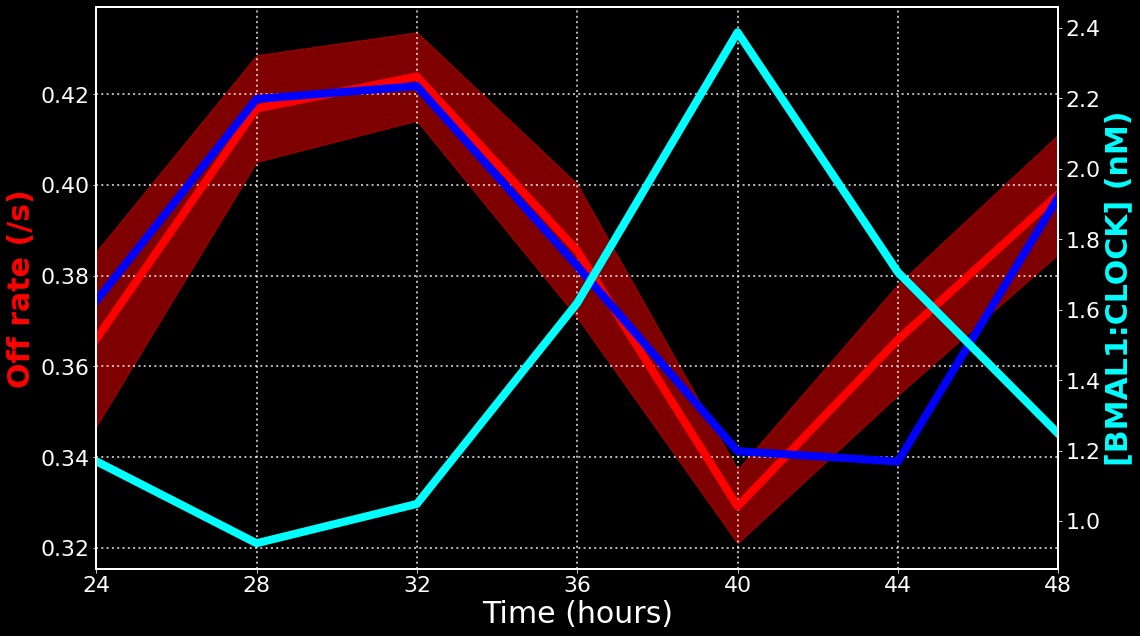

In [44]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Off rate (/s)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
ax1.plot(tps, kOFF, color=red, linewidth=8)
ax1.plot(tps, kOFF_sim, color='blue', linewidth=8)
#ax1.fill_between(tps, kOFF - kOFF_std/kOFF_N, kOFF + kOFF_std/kOFF_N, color=red, alpha=0.5)
ax1.fill_between(tps, kOFF - kOFF_SEM, kOFF + kOFF_SEM, color=red, alpha=0.5)

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[BMAL1:CLOCK] (nM)', weight='bold', color='cyan')
ax2.plot(tps, equilibrium_conc_sim[:, var['CB']], color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


cheese


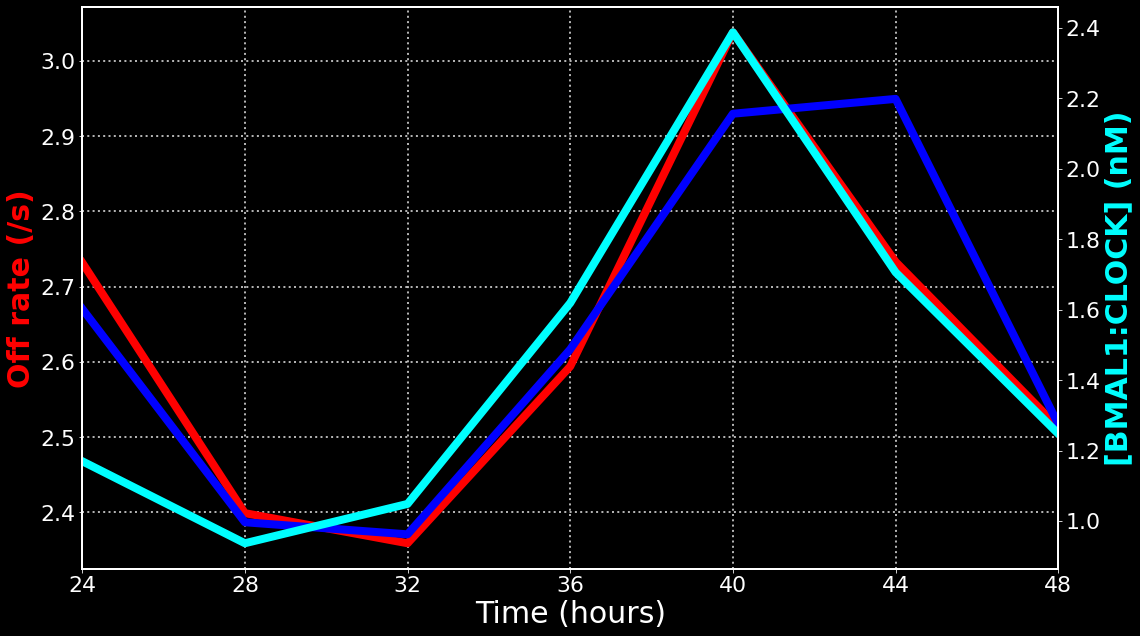

In [45]:
print('cheese')
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Off rate (/s)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
ax1.plot(tps, 1/kOFF, color=red, linewidth=8)
ax1.plot(tps, 1/kOFF_sim, color='blue', linewidth=8)
#ax1.fill_between(tps, kOFF - kOFF_std/kOFF_N, kOFF + kOFF_std/kOFF_N, color=red, alpha=0.5)
#ax1.fill_between(tps, kOFF - kOFF_SEM, kOFF + kOFF_SEM, color=red, alpha=0.5)

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[BMAL1:CLOCK] (nM)', weight='bold', color='cyan')
ax2.plot(tps, equilibrium_conc_sim[:, var['CB']], color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


cheese


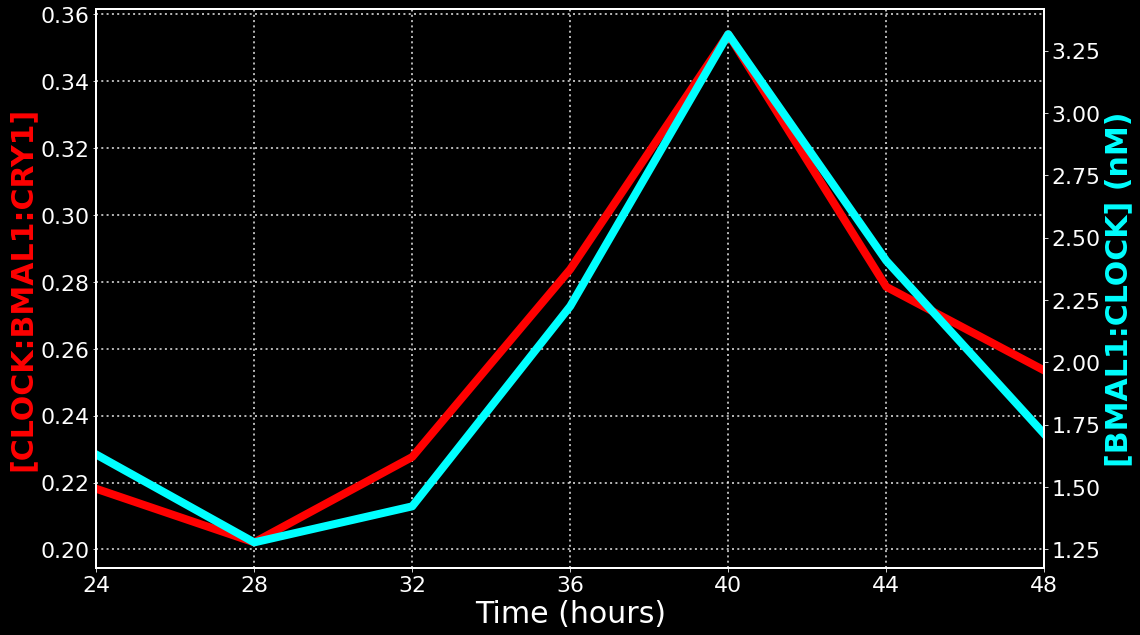

In [46]:
print('cheese')
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('[CLOCK:BMAL1:CRY1]', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
all_CBC1 = equilibrium_conc_sim[:, var['CBC1P2']] + equilibrium_conc_sim[:, var['CBC1']] #+ equilibrium_conc_sim[:, var['CBC1S']] + equilibrium_conc_sim[:, var['CBC1P2S']]
ax1.plot(tps, all_CBC1, color=red, linewidth=8)

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[BMAL1:CLOCK] (nM)', weight='bold', color='cyan')
all_CB = equilibrium_conc_sim[:, var['CB']] + equilibrium_conc_sim[:, var['CBS']]
ax2.plot(tps, all_CB , color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


cheese


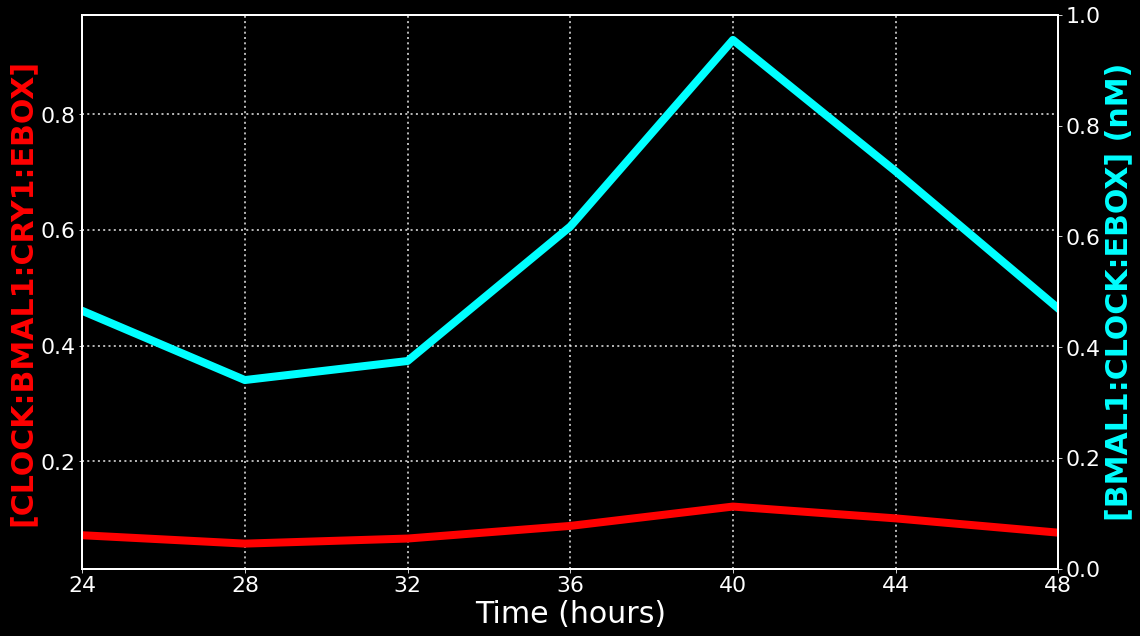

In [47]:
print('cheese')
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('[CLOCK:BMAL1:CRY1:EBOX]', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time') #+ equilibrium_conc_sim[:, var['CBC1S']] + equilibrium_conc_sim[:, var['CBC1P2S']]
ax1.plot(tps, equilibrium_conc_sim[:, var['CBC1S']], color=red, linewidth=8)
ax1.plot(tps, equilibrium_conc_sim[:, var['CBS']], color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[BMAL1:CLOCK:EBOX] (nM)', weight='bold', color='cyan')
all_CB = equilibrium_conc_sim[:, var['CB']] + equilibrium_conc_sim[:, var['CBS']]
#ax2.plot(tps, equilibrium_conc_sim[:, var['CBS']], color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


cheese


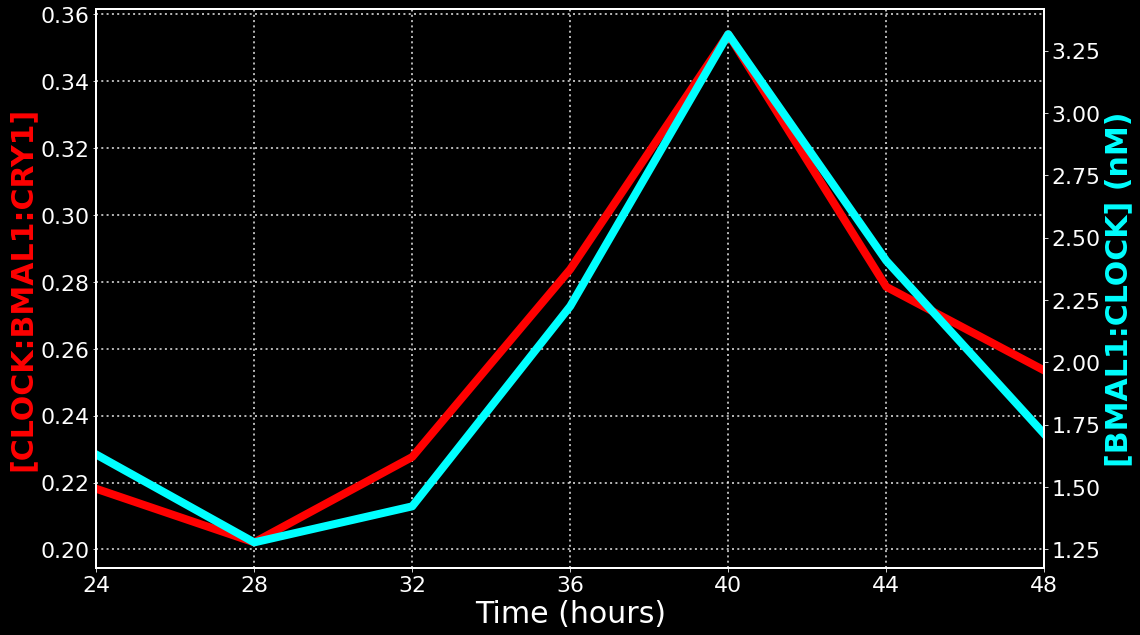

In [48]:
print('cheese')
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('[CLOCK:BMAL1:CRY1]', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, kOFF_sim, color=red, linewidth=8, label='Residence time')
#ax1.plot(tps, signal.savgol_filter(kOFF_sim, 11, 3) , color=red, linewidth=8, label='Residence time')
all_CBC1 = equilibrium_conc_sim[:, var['CBC1P2']] + equilibrium_conc_sim[:, var['CBC1']] #+ equilibrium_conc_sim[:, var['CBC1S']] + equilibrium_conc_sim[:, var['CBC1P2S']]
ax1.plot(tps, all_CBC1, color=red, linewidth=8)

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('[BMAL1:CLOCK] (nM)', weight='bold', color='cyan')
all_CB = equilibrium_conc_sim[:, var['CB']] + equilibrium_conc_sim[:, var['CBS']]
ax2.plot(tps,all_CB , color='cyan', linewidth=8, label='BMAL1-CRY1 Kd')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()


In [48]:
data_fitted_solution[0]

array([3.73700515e-01, 1.16378836e+00, 5.61233057e+00, 4.71284962e-01,
       8.18808159e+00, 2.08263466e-01, 7.35050306e-02, 5.16779438e+00,
       5.16028317e-01, 3.92641193e-03, 1.37935152e-02, 9.92040409e+00,
       1.73872456e+01, 3.04617907e+00, 1.92013594e-01])

NameError: name 'data_fitted_solution' is not defined

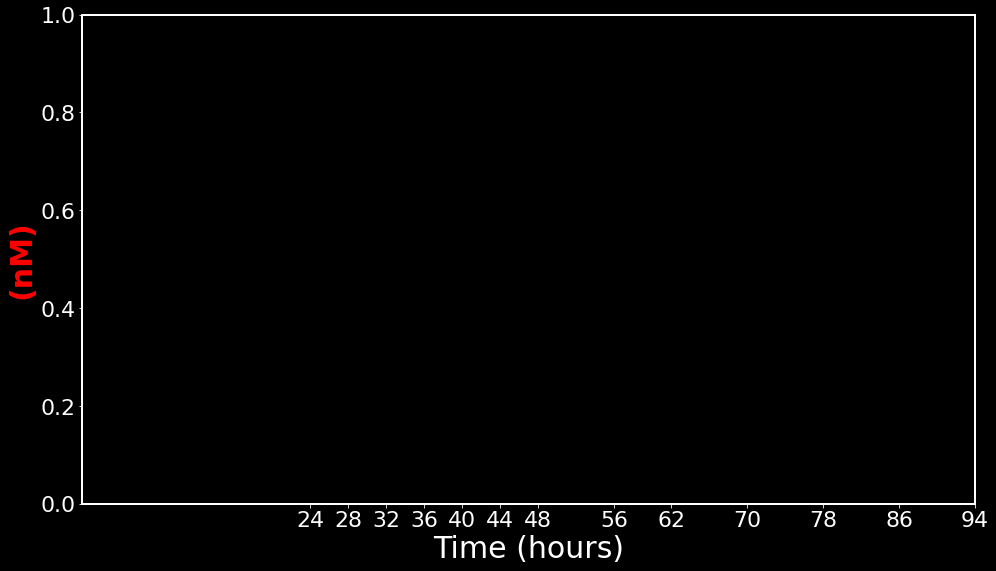

In [28]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('(nM)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, 1/kOFF, color=red, linewidth=8, label='Residence time')
ax1.plot(tps, data_fitted_solution[:, var['CBS']+1], '-', color='blue', linewidth=8, label='Residence time')
ax1.plot(tps, data_fitted_solution[:, var['CBC1S']+1], '-', color='cyan', linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim[:, 0], 'o', color='darkred', label='Noisy data')
#ax1.plot(tps, fitted_Y[:, 0], 'o', color='blue', label='Fit')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
ax2.set_ylabel('(nM)', weight='bold', color=green)
ax2.plot(tps, data_fitted_solution[:, var['CBC1']+1], color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

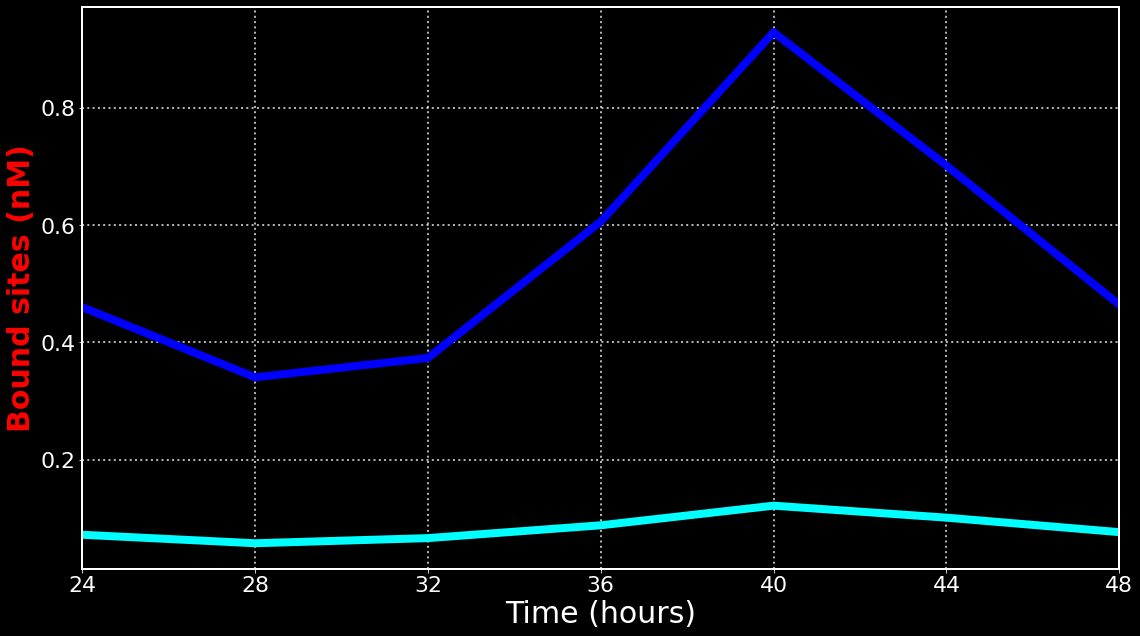

In [49]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Bound sites (nM)', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, 1/kOFF, color=red, linewidth=8, label='Residence time')
ax1.plot(tps, equilibrium_conc_sim[:, var['CBS']], '-', color='blue', linewidth=8, label='Residence time')
ax1.plot(tps, equilibrium_conc_sim[:, var['CBC1S']], '-', color='cyan', linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim[:, 0], 'o', color='darkred', label='Noisy data')
#ax1.plot(tps, fitted_Y[:, 0], 'o', color='blue', label='Fit')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
#ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
#ax2.set_ylabel('(nM)', weight='bold', color=green)
#ax2.plot(tps, data_fitted_solution[:, var['CBC1']+1], color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

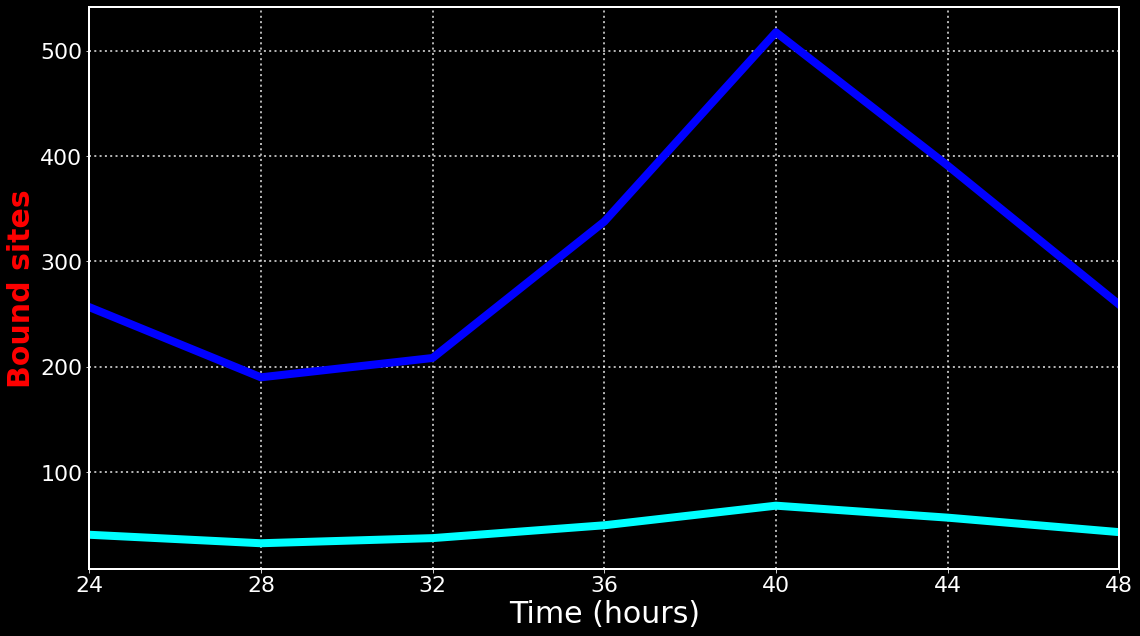

In [50]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Bound sites', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, 1/kOFF, color=red, linewidth=8, label='Residence time')
ax1.plot(tps, 1E-9 * N_A * V* equilibrium_conc_sim[:, var['CBS']], '-', color='blue', linewidth=8, label='Residence time')
ax1.plot(tps, 1E-9 * N_A * V*equilibrium_conc_sim[:, var['CBC1S']], '-', color='cyan', linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim[:, 0], 'o', color='darkred', label='Noisy data')
#ax1.plot(tps, fitted_Y[:, 0], 'o', color='blue', label='Fit')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
#ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
#ax2.set_ylabel('(nM)', weight='bold', color=green)
#ax2.plot(tps, data_fitted_solution[:, var['CBC1']+1], color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

In [2]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Bound sites', color=red, weight='bold')
ax1.set_xticks([24, 28, 32, 36, 40, 44, 48, 56, 62, 70, 78, 86, 94])
#ax1.plot(tps, 1/kOFF, color=red, linewidth=8, label='Residence time')
ax1.plot(tps, data_fitted_solution[:, var['CBS']+1]/S, '-', color='blue', linewidth=8, label='Residence time')
ax1.plot(tps, data_fitted_solution[:, var['CBC1S']+1]/S, '-', color='cyan', linewidth=8, label='Residence time')
#ax1.plot(tps, Y_sim[:, 0], 'o', color='darkred', label='Noisy data')
#ax1.plot(tps, fitted_Y[:, 0], 'o', color='blue', label='Fit')

#plt.plot(ct, PER2s, label='PER2')
ax1.set_xlim([24, 48])
#ax2 = ax1.twinx()
#ax2.grid()
ax1.grid(which='major')
#ax2.set_ylabel('(nM)', weight='bold', color=green)
#ax2.plot(tps, data_fitted_solution[:, var['CBC1']+1], color=green, linewidth=8, label='Per2')
#ax1.legend()()
#ax2.legend(bbox_to_anchor=(0.92, 0.9))
fig.tight_layout()
#plt.savefig('Outputs/residence_plot.svg', transparent=True, format='svg')
#plt.grid()
plt.show()

NameError: name 'plt' is not defined

In [56]:
data_fitted_solution.shape

(7, 19)

In [51]:
column_names =[
    'kOFF',
    'CB',
    'S',
    'CBS',
    'C1',
    'CBC1',
    'CBC1S',
    'P2',
    'C1P2',
    'CBC1P2S',
    'CBC1P2',
    'C',
    'B',
    'BC1',
    'BC1P2'
]
len(column_names)

15

In [38]:
data_fitted_solution.shape

(7, 15)

In [34]:
result

array([[3.74435312e-01, 1.09718958e+00, 5.65446377e+00, 4.33982498e-01,
        8.19321560e+00, 1.92565764e-01, 6.83696281e-02, 5.16786291e+00,
        5.16358720e-01, 4.23107723e-03, 1.21777001e-02, 9.50927681e+00,
        1.70363813e+01, 2.98948790e+00, 1.88441734e-01],
       [4.18954938e-01, 8.87383914e-01, 5.77765115e+00, 3.23707536e-01,
        7.70694308e+00, 1.76751942e-01, 5.51481475e-02, 6.86946936e+00,
        6.45641578e-01, 4.54013253e-03, 1.48502655e-02, 8.71754160e+00,
        1.50302889e+01, 2.99317597e+00, 2.50787177e-01],
       [4.21790083e-01, 9.91403505e-01, 5.73804435e+00, 3.54558223e-01,
        1.05025676e+01, 1.99111093e-01, 6.33726041e-02, 6.67856092e+00,
        8.55390704e-01, 5.07179667e-03, 1.62651617e-02, 9.19629127e+00,
        1.59179754e+01, 3.19627493e+00, 2.60364629e-01],
       [3.82157783e-01, 1.51051652e+00, 5.50237139e+00, 5.69469224e-01,
        8.42604385e+00, 2.47128676e-01, 8.33182318e-02, 5.90009618e+00,
        6.06274014e-01, 5.88812564e-0

In [52]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/20-7-21 fitting concs.xlsx")

In [53]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/20-7-21 fitting nums.xlsx")

## Mean locking for figure S8

In [34]:
initial_concentrations_CB_mean = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_CB_mean[:, var['S']] = S
initial_concentrations_CB_mean[:, var['B']] = np.array([np.mean(Bmal1)]*samples)
initial_concentrations_CB_mean[:, var['C']] = np.array([np.mean(Clock)]*samples)
initial_concentrations_CB_mean[:, var['C1']] = Cry1
initial_concentrations_CB_mean[:, var['P2']] = Per2
initial_concentrations_CB_mean = initial_concentrations_CB_mean.astype('float64')

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
ode_model_CB_mean = DNA_binding_model_B1(samples, initial_concentrations_CB_mean, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s, cores=20)

result_CB_mean = ode_model_CB_mean.full_simulate(fitted_params)
kOFF_sim_CB_mean = result_CB_mean[:, 0]
equilibrium_conc_sim_CB_mean = np.array([el[1:] for el in result_CB_mean])
kOFF_sim_CB_mean

4

array([0.37108506, 0.41290025, 0.41435871, 0.3838073 , 0.34641339,
       0.34112836, 0.39576034])

In [35]:
initial_concentrations_CRY1_mean = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_CRY1_mean[:, var['S']] = S
initial_concentrations_CRY1_mean[:, var['B']] = Bmal1
initial_concentrations_CRY1_mean[:, var['C']] = Clock
initial_concentrations_CRY1_mean[:, var['C1']] = np.mean([Cry1]*samples)
initial_concentrations_CRY1_mean[:, var['P2']] = Per2
initial_concentrations_CRY1_mean = initial_concentrations_CRY1_mean.astype('float64')

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
ode_model_CRY1_mean = DNA_binding_model_B1(samples, initial_concentrations_CRY1_mean, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s, cores=20)

result_CRY1_mean = ode_model_CRY1_mean.full_simulate(fitted_params)
kOFF_sim_CRY1_mean = result_CRY1_mean[:, 0]
equilibrium_conc_sim_CRY1_mean = np.array([el[1:] for el in result_CRY1_mean])
kOFF_sim_CRY1_mean

5

array([0.3792413 , 0.43285219, 0.40393477, 0.38184853, 0.33757057,
       0.3407724 , 0.40310453])

In [39]:
initial_concentrations_PER2_mean = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_PER2_mean[:, var['S']] = S
initial_concentrations_PER2_mean[:, var['B']] = Bmal1
initial_concentrations_PER2_mean[:, var['C']] = Clock
initial_concentrations_PER2_mean[:, var['C1']] = Cry1
initial_concentrations_PER2_mean[:, var['P2']] = np.mean([Per2]*samples)
initial_concentrations_PER2_mean = initial_concentrations_PER2_mean.astype('float64')

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
ode_model_PER2_mean = DNA_binding_model_B1(samples, initial_concentrations_PER2_mean, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s, cores=20)

result_PER2_mean = ode_model_PER2_mean.full_simulate(fitted_params)
kOFF_sim_PER2_mean = result_PER2_mean[:, 0]
equilibrium_conc_sim_PER2_mean = np.array([el[1:] for el in result_PER2_mean])
kOFF_sim_PER2_mean

7

array([0.38144997, 0.39590978, 0.39327708, 0.37504081, 0.36039129,
       0.36923717, 0.38936626])

In [40]:
initial_concentrations_INT_mean = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_INT_mean[:, var['S']] = S
initial_concentrations_INT_mean[:, var['B']] = Bmal1
initial_concentrations_INT_mean[:, var['C']] = Clock
initial_concentrations_INT_mean[:, var['C1']] = Cry1
initial_concentrations_INT_mean[:, var['P2']] = Per2
initial_concentrations_INT_mean = initial_concentrations_INT_mean.astype('float64')

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
ode_model_INT_mean = DNA_binding_model_B1(samples, initial_concentrations_INT_mean, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, np.array([np.mean(kd_CB_C1s)]*samples), cores=20)

result_INT_mean = ode_model_INT_mean.full_simulate(fitted_params)
kOFF_sim_INT_mean = result_INT_mean[:, 0]
equilibrium_conc_sim_INT_mean = np.array([el[1:] for el in result_INT_mean])
kOFF_sim_INT_mean

8

array([0.36965294, 0.39987879, 0.4239533 , 0.38375665, 0.35322153,
       0.34269833, 0.38468331])

In [43]:
initial_concentrations_C1P2_mean = np.array([np.array([0.0]*14)]*samples)
initial_concentrations_C1P2_mean[:, var['S']] = S
initial_concentrations_C1P2_mean[:, var['B']] = Bmal1
initial_concentrations_C1P2_mean[:, var['C']] = Clock
initial_concentrations_C1P2_mean[:, var['C1']] = np.mean([Cry1]*samples)
initial_concentrations_C1P2_mean[:, var['P2']] = np.mean([Per2]*samples)
initial_concentrations_C1P2_mean = initial_concentrations_C1P2_mean.astype('float64')

fitted_params = [0.02684237,  1.15950765,  7.79829319,  0.07119545, 12.53193821, 0.7362028 ]
ode_model_C1P2_mean = DNA_binding_model_B1(samples, initial_concentrations_C1P2_mean, 20000, int(1E5), kd_C1_P2, CB_EBOX_Kd, kd_CB, kd_CB_C1s, cores=20)

result_C1P2_mean = ode_model_C1P2_mean.full_simulate(fitted_params)
kOFF_sim_C1P2_mean = result_C1P2_mean[:, 0]
equilibrium_conc_sim_C1P2_mean = np.array([el[1:] for el in result_C1P2_mean])
kOFF_sim_C1P2_mean

9

array([0.38706462, 0.40484032, 0.38031847, 0.37520022, 0.35589692,
       0.3713798 , 0.39402928])

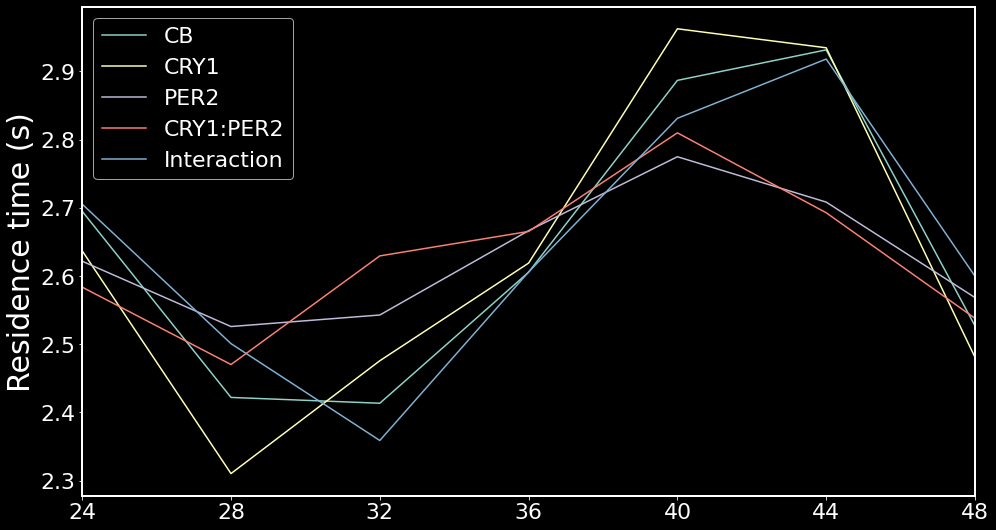

In [64]:
plt.plot(tps, 1/kOFF_sim_CB_mean, label='CB')
plt.plot(tps, 1/kOFF_sim_CRY1_mean, label='CRY1')
plt.plot(tps, 1/kOFF_sim_PER2_mean, label='PER2')
plt.plot(tps, 1/kOFF_sim_C1P2_mean, label='CRY1:PER2')
plt.plot(tps, 1/kOFF_sim_INT_mean, label='Interaction')
plt.xlim([24, 48])
plt.xticks([24, 28, 32, 36, 40, 44, 48])
plt.ylabel('Residence time (s)')
plt.legend()

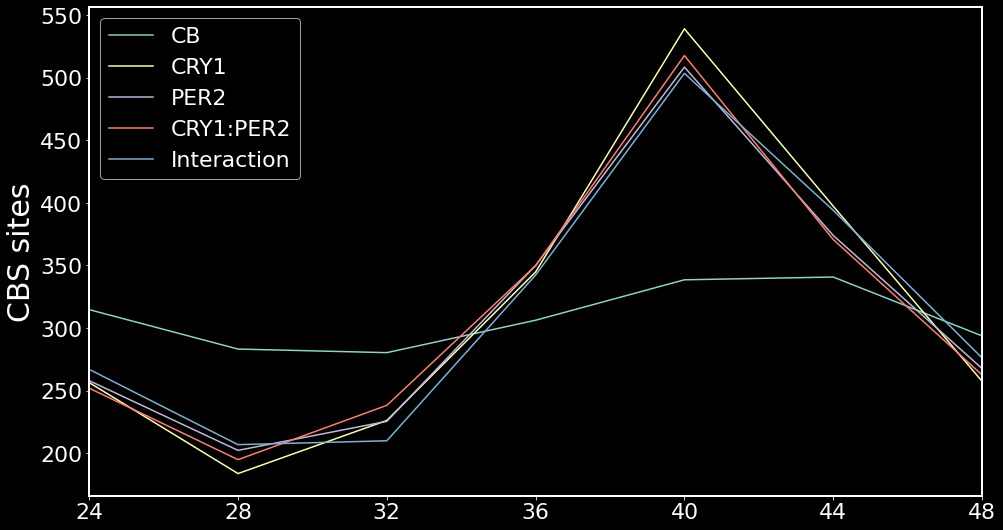

In [65]:
plt.plot(tps, 1E-9 * N_A * V * equilibrium_conc_sim_CB_mean[:, var['CBS']], label='CB')
plt.plot(tps, 1E-9 * N_A * V *equilibrium_conc_sim_CRY1_mean[:, var['CBS']], label='CRY1')
plt.plot(tps, 1E-9 * N_A * V *equilibrium_conc_sim_PER2_mean[:, var['CBS']], label='PER2')
plt.plot(tps, 1E-9 * N_A * V *equilibrium_conc_sim_C1P2_mean[:, var['CBS']], label='CRY1:PER2')
plt.plot(tps, 1E-9 * N_A * V *equilibrium_conc_sim_INT_mean[:, var['CBS']], label='Interaction')
plt.xlim([24, 48])
plt.xticks([24, 28, 32, 36, 40, 44, 48])
plt.ylabel('CBS sites')
plt.legend()

In [52]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_CB_mean
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CB mean concs.xlsx")

In [53]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_CB_mean
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CB mean nums.xlsx")

In [54]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_CRY1_mean
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CRY1 mean concs.xlsx")

In [55]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_CRY1_mean
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CRY1 mean nums.xlsx")

In [56]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_PER2_mean
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 PER2 mean concs.xlsx")

In [57]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_PER2_mean
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 PER2 mean nums.xlsx")

In [60]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_C1P2_mean
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CRY1:PER2 mean concs.xlsx")

In [61]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_C1P2_mean
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 CRY1:PER2 mean nums.xlsx")

In [62]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_INT_mean
nums[:, 1:] = nums[:, 1:] #* 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 interaction mean concs.xlsx")

In [63]:
time_points = [24, 28, 32, 36, 40, 44, 48]

nums = result_INT_mean
nums[:, 1:] = nums[:, 1:] * 1E-9 * N_A * V
df_save = pd.DataFrame(nums, columns=column_names, index=time_points)
            
df_save.to_excel("/home/research/alexkoch/DNA binding paper/Model D.1/D.1c ChIP outputs/23-7-21 interaction mean nums.xlsx")